# CASSIOPE-FAI-Map-Projection
***

**Tutorial :** This tutorial explains how to visualize data from the FAI camera with various map projections.    
**Mission and Instrument :** FAI (Fast Auroral Imager) on CASSIOPE       
**Astronomical Target :** Auroral emissions    
**Primary Tools :** Python3 script     
**Tutorial Level :** Intermediate

Pictures of the Earth can be difficult to visualize, espicially the Poles. There is a variety of map projections to visualize a realistic image of the globe. The goal of this tutorial is to test map projections from the *Cartopy* module of *Matplotlib* with the FAI picture. This tutorial includes two types of visualization :

1. A zoomed picture of the FAI image ;
2. A more general map with a zoomed window of the FAI image.

Here is a list of [map projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) supported by *Cartopy*.

## Library

The following script uses

* *numpy* : mathematical operation and multidimensional array
* *h5py* : open .h5 files
* *pandas* : dataframe structure
* *matplotlib* : plot figures
* *cartopy* : plot maps

In [111]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import h5py

## Zoomed map

We have a function to create the map. On the map, the FAI image will be plotted with margins around.

In [134]:
# Function plotting a zoomed map
# Parameters
# lon : the longitude of the picture (array of float)
# lat : the latitude of the picture (array of float)
# proj : the map projection id to use (string)
# interPara : the interval between parallel label (float)
# interMeri : the interval between meridian label (float)
# lonmargins : the margins on the x-axis (longitude) (float)
# latmargins : the margins on the y-axis (latitude) (float)
# Returns the map
def createZoomedMap(lon,lat,proj,interPara,interMeri,lonmargins,latmargins):
    
    # We want a small map
    width=400000
    height=200000
    minlon = np.nanmin(lon)-lonmargins
    maxlon = np.nanmax(lon)+lonmargins
    minlat = np.nanmin(lat)-latmargins
    maxlat = np.nanmax(lat)+latmargins
    lat_0=lat[139][127]
    lon_0=lon[139][127]
    
    # Albers Equal Area
    plt.figure(figsize=(6, 6))
    if(proj in ['aea']):
        ax = plt.axes(projection=ccrs.AlbersEqualArea(lon_0, lat_0))
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Azimuthal Equidistant
    elif(proj in ['aeqd']):
        ax = plt.axes(projection=ccrs.AzimuthalEquidistant(central_latitude=90))
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Equidistant Conic
    elif(proj in ['eqdc']):
        ax = plt.axes(projection=ccrs.EquidistantConic(lon_0, lat_0))
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Lambert Conformal
    elif(proj in ['lcc']):
        ax = plt.axes(projection=ccrs.LambertConformal(lon_0, lat_0))
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Lambert Azimuthal Equal Area
    elif(proj in ['laea','cyl']):
        ax = plt.axes(projection=ccrs.LambertCylindrical())
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Goode Homolosine
    elif(proj in ['goode']):
        ax = plt.axes(projection=ccrs.InterruptedGoodeHomolosine(emphasis='land'))
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Stereographic
    elif(proj in ['stere']):
        ax = plt.axes(projection=ccrs.Stereographic(lon_0, lat_0))
        ax.coastlines(resolution='110m')
        ax.gridlines()
        ax.stock_img()
        ax.set_global()
    # Orthographic
    elif(proj in ['ortho']):
        ax = plt.axes(projection=ccrs.Orthographic(lon_0, lat_0))
        ax.coastlines(resolution='110m')
        ax.add_feature(cartopy.feature.OCEAN, zorder=0)
        ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
        ax.set_global()
        ax.gridlines()
    # Near-Sided Perspective
    elif(proj in ['nsper']):
        ax = plt.axes(projection=ccrs.NearsidePerspective(lon_0))
        ax.coastlines(resolution='110m')
        ax.add_feature(cartopy.feature.OCEAN, zorder=0)
        ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
        ax.set_global()
        ax.gridlines()
    # For other projections
    else:
        ax = plt.axes(projection=ccrs.Mollweide())
        ax.stock_img()
        ax.set_global()
    
    return (ax)

Now, let's see how the image is plotted on the map.

In [135]:
# Function plotting a FAI image on a zoomed map
# Parameters :
# file : the path to the file (string)
# proj : the map projection id to use (string)
# title : title of the figure (string)
# pct : top percentage brightness values to plot in white (default=0.01) (float)
# interPara : the interval between parallel label (default=2.) (float)
# interMeri : the interval between meridian label (defualt-5.) (float)
# Returns nothing
def plotZoomedMap(file, proj, title, lonmargins=2., latmargins=1., pct=0.01, interPara=1., interMeri=2.):
    
    # List of the supported projection of this script
    supportedProjection = ['ortho','nsper','cyl','mill', 'goode', 'stere', 'aea',
                           'eqdc','aeqd','lcc','laea']
    
    # If it's a different projection, stop
    if(proj not in supportedProjection):
        print("\nERROR: Unknown projection")
        return()
    
    # Open the file and extract the latitudes, longitudes, image and conversion factor
    with h5py.File(file, 'r') as f:
        keys = f.attrs.keys()
        values = f.attrs.values()
        attributes = pd.DataFrame(values, keys)
        conversion = int(attributes.loc['DN to Rayleigh Conversion Factor (R/DN/s)'])
        date_utc = str(attributes.loc['UTC'])
        image = np.array(f.get('FAI Image'))/conversion
        lat = np.array(f.get('Pixel Latitudes'))
        lon = np.array(f.get('Pixel Longitudes'))
    
    # Remove the last row and column, since they only indicate 
    # the bottom right corner of the image
    lat = np.delete(lat,lat.shape[0]-1,0) 
    lat = np.delete(lat,lat.shape[1]-1,1) 
    lon = np.delete(lon,lon.shape[0]-1,0) 
    lon = np.delete(lon,lon.shape[1]-1,1)
    
    # Adjust the date
    date_utc = date_utc[4:24].replace('T', ' ')
    
    # Create the map
    m = createZoomedMap(lon,lat,proj,interPara,interMeri,lonmargins,latmargins)
    m.plot(lon[139][127], lat[139][127],
         color='blue', linewidth=2, marker='o',
         transform=ccrs.Geodetic(),
         )
    
    # Show the zoom map
    fig = plt.figure(figsize=(8, 8))
    img_extent = (lon[139][127]-6.4, lon[139][127]+6.4, lat[139][127]-8.4, lat[139][127]+8.4)
    zoom_ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title(title + '\n' + date_utc + '\nLatitude: {:.2f}'.format(lat[139][127]) + '\nLongitude: {:.2f}'.format(lon[139][127]))

    # Set a margin around the data
    zoom_ax.set_xmargin(0.05)
    zoom_ax.set_ymargin(0.10)

    # Add the image
    zoom_ax.imshow(image, origin='lower', extent=img_extent, transform=ccrs.PlateCarree())
    zoom_ax.coastlines(resolution='50m', color='black', linewidth=1)
    plt.show()
    
    return()    

Let's test it out!

In [136]:
file='FAI_lv1_NIR_20190501_183357_183357_6.0.0.h5'

hi
  


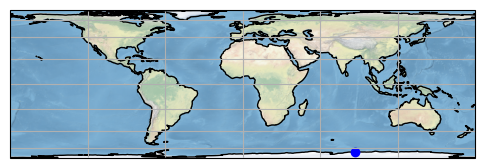

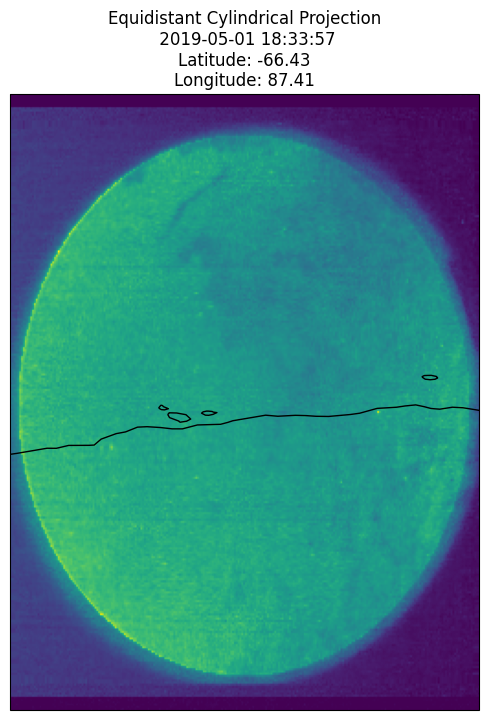

()

In [137]:
plotZoomedMap(file,'cyl', 'Equidistant Cylindrical Projection')

hi
  


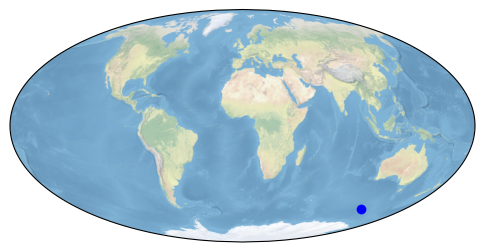

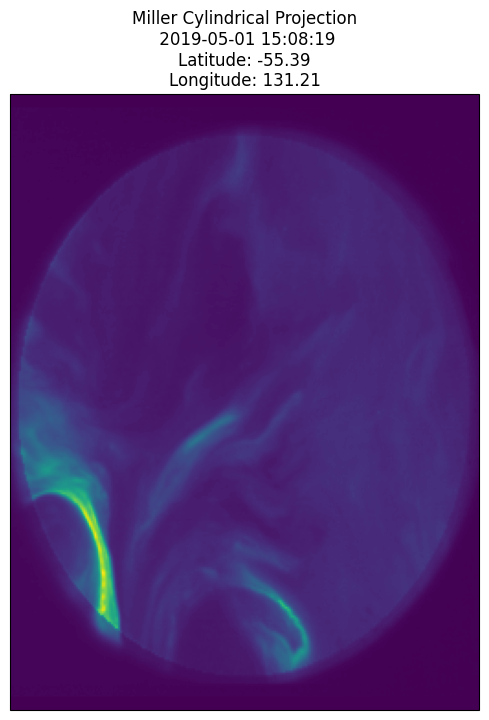

()

In [138]:
file='FAI_lv1_NIR_20190501_150819_150819_6.0.0.h5'
plotZoomedMap(file,'mill', 'Miller Cylindrical Projection')

hi
  


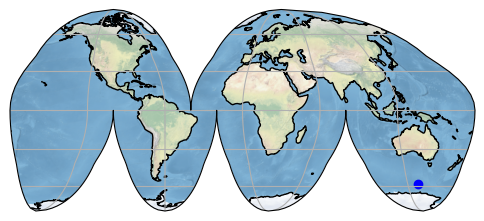

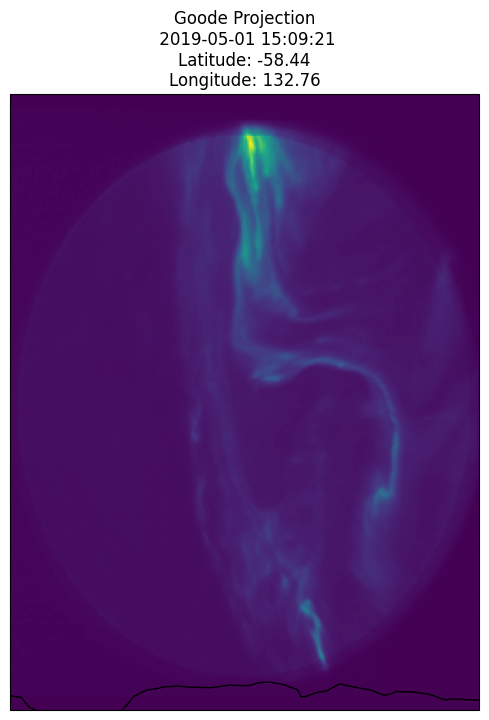

()

In [139]:
file='FAI_lv1_NIR_20190501_150921_150921_6.0.0.h5'
plotZoomedMap(file, 'goode', 'Goode Projection')

hi
  


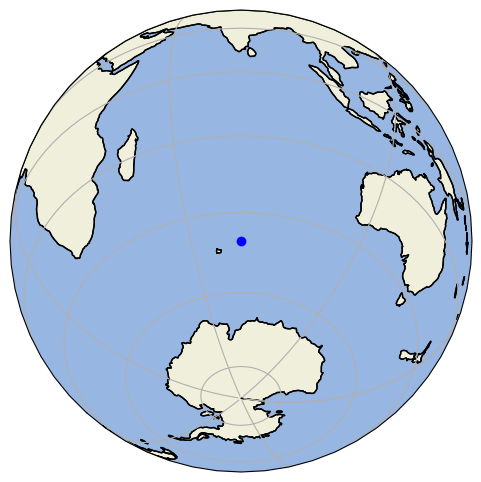

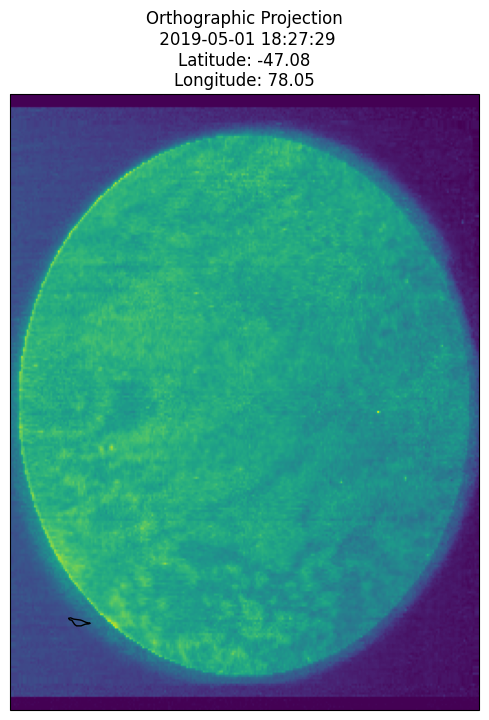

()

In [140]:
file='FAI_lv1_NIR_20190501_182729_182729_6.0.0.h5'
plotZoomedMap(file, 'ortho', 'Orthographic Projection')

hi
  


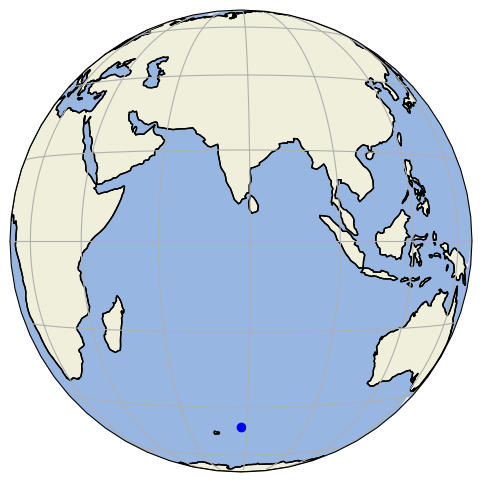

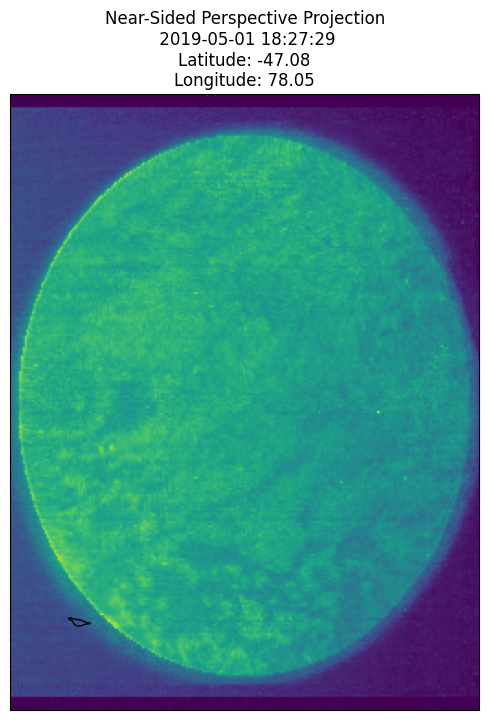

()

In [141]:
plotZoomedMap(file, 'nsper', 'Near-Sided Perspective Projection')

hi
  


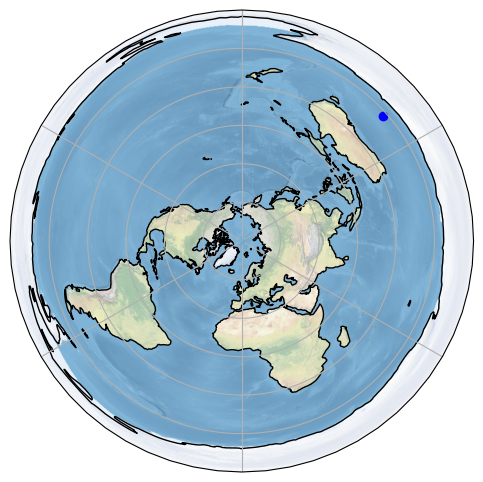

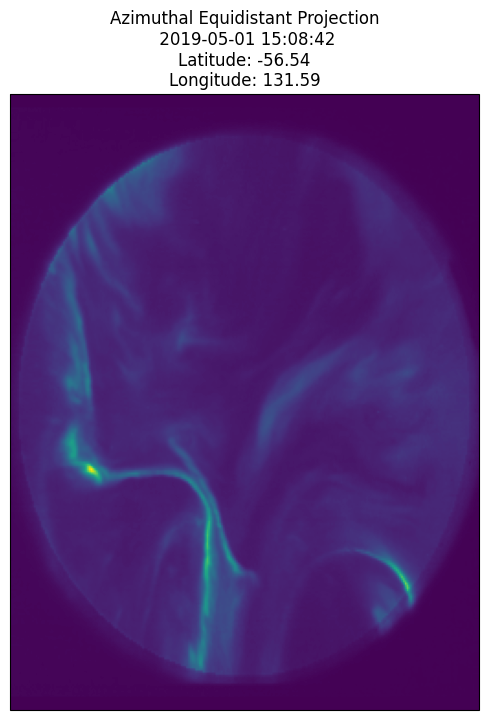

()

In [142]:
file='FAI_lv1_NIR_20190501_150842_150842_6.0.0.h5'
plotZoomedMap(file, 'aeqd', 'Azimuthal Equidistant Projection')

**Rectangulair maps with transformation**

hi
  


Stereo Projection


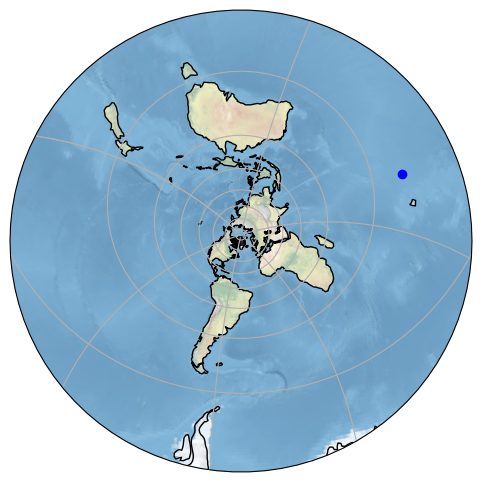

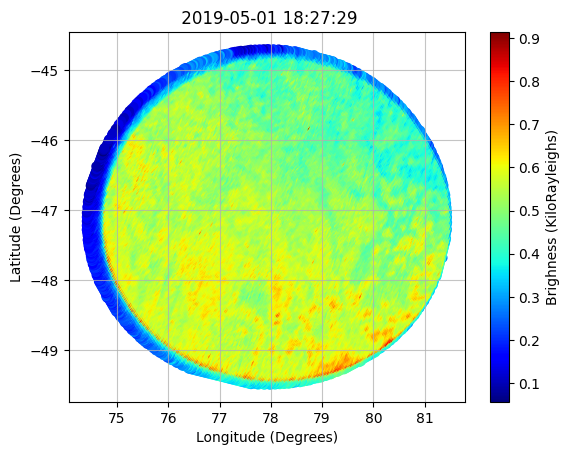

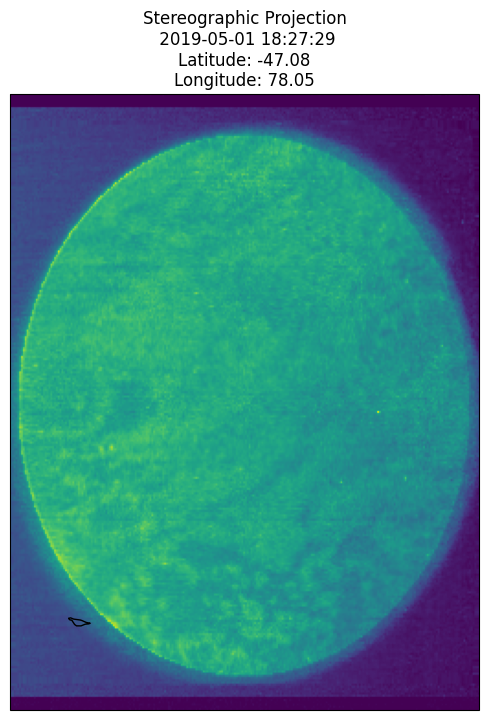

()

In [104]:
file='FAI_lv1_NIR_20190501_182729_182729_6.0.0.h5'
plotZoomedMap(file, 'stere', 'Stereographic Projection')

hi
  


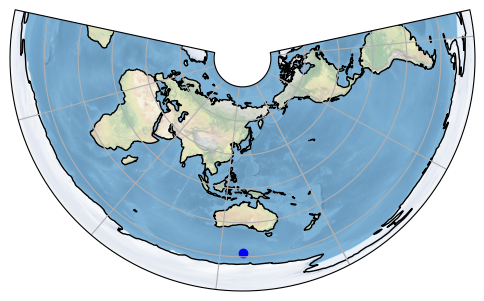

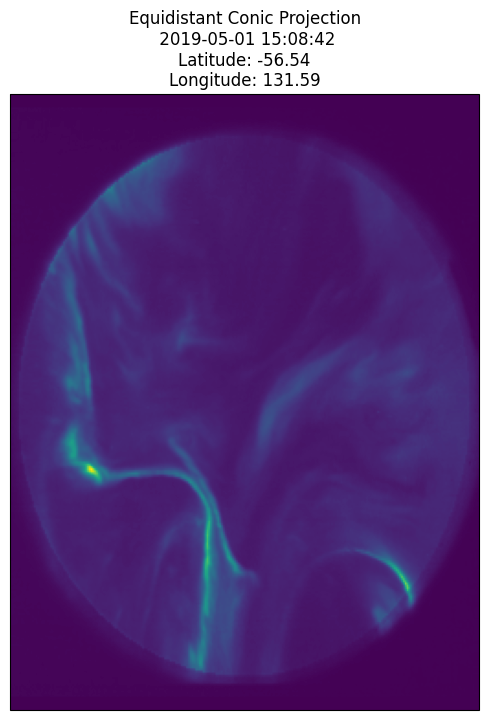

()

In [143]:
plotZoomedMap(file, 'eqdc', 'Equidistant Conic Projection')

hi
  


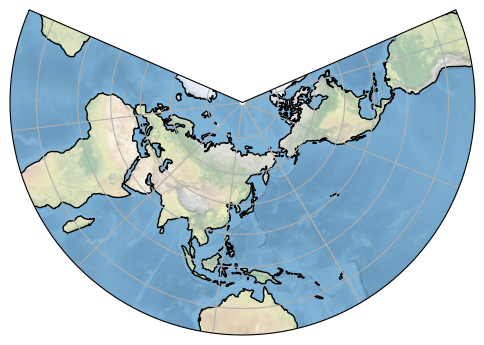

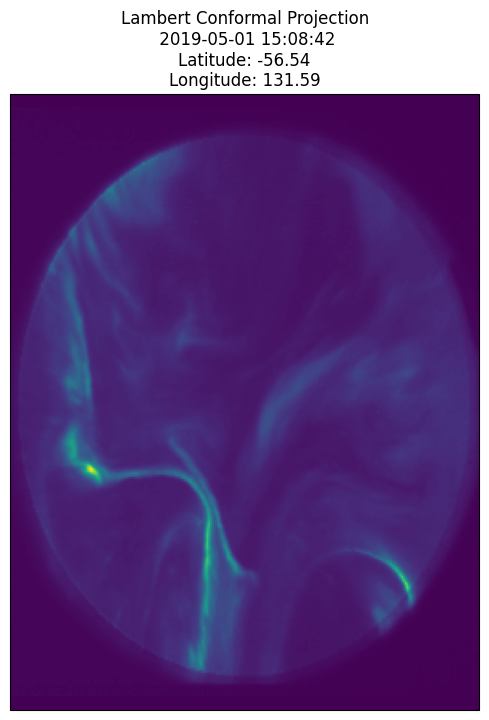

()

In [144]:
plotZoomedMap(file, 'lcc', 'Lambert Conformal Projection')

hi
  


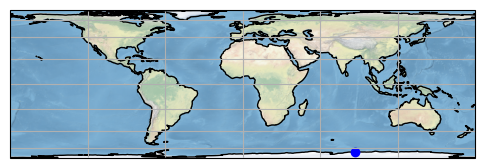

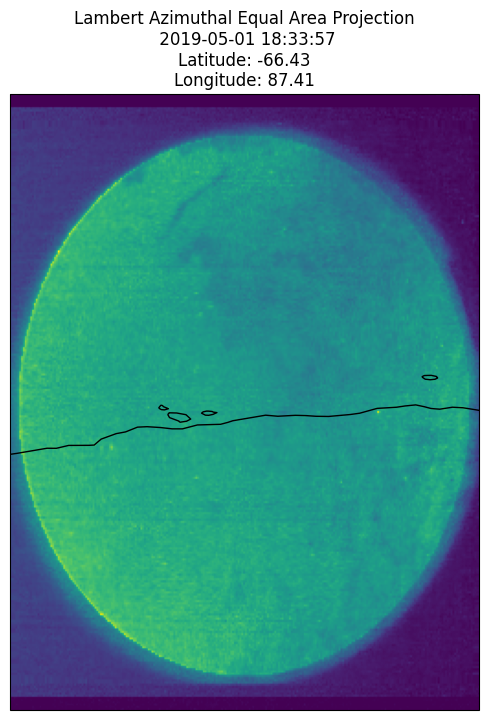

()

In [145]:
file='FAI_lv1_NIR_20190501_183357_183357_6.0.0.h5'
plotZoomedMap(file, 'laea', 'Lambert Azimuthal Equal Area Projection')

hi
  


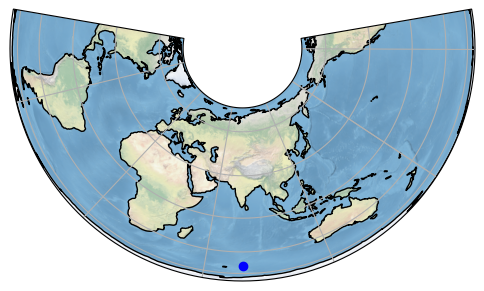

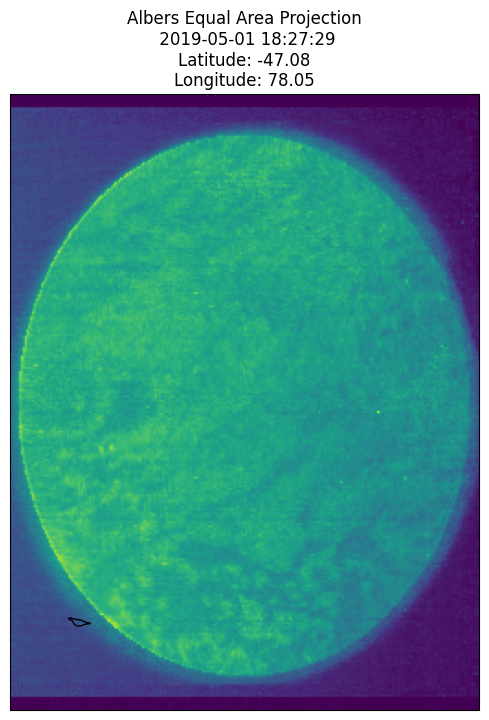

()

In [146]:
file='FAI_lv1_NIR_20190501_182729_182729_6.0.0.h5'
plotZoomedMap(file, 'aea', 'Albers Equal Area Projection')

In [147]:
plt.close('all')